In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import json

import os
import sys

In [17]:
import firebase_admin
from firebase_admin import credentials, storage

cred = credentials.Certificate('./b-sc-402909-firebase-adminsdk-yuf0e-000953c2f9.json')

if not firebase_admin._apps:
    firebase_admin.initialize_app(cred, {'storageBucket': 'b-sc-402909.appspot.com'})

bucket = storage.bucket()

folder_path = 'mousemovements/'

os.makedirs(folder_path, exist_ok=True)

blobs = bucket.list_blobs(prefix=folder_path)

for blob in blobs:
    print(f"Processing {blob.name}")
    if blob.name != folder_path:
        # Create the folder if it does not exist
        os.makedirs(os.path.dirname(blob.name), exist_ok=True)

        # Construct the local file path by replacing the folder path in the blob name
        local_file_path = os.path.join(folder_path, blob.name.replace(folder_path, ''))

        # Check if the file already exists
        if os.path.exists(local_file_path):
            print(f"File {local_file_path} already exists")
            continue

        # Download the file
        blob.download_to_filename(local_file_path)
        print(f"Downloaded {blob.name} to {local_file_path}")

Processing mousemovements/
Processing mousemovements/0/mousemovements0.json
File mousemovements/0/mousemovements0.json already exists
Processing mousemovements/1/mousemovements0.json
Downloaded mousemovements/1/mousemovements0.json to mousemovements/1/mousemovements0.json


In [18]:
IMG_DIR = './images'

# Load images
imgs = {}

for im in sorted(os.listdir(IMG_DIR)):
    if im.endswith('.jpg'):
        img_path = os.path.join(IMG_DIR, im)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs[im] = img

In [19]:
mouse_positions = {}
final_positions = {}
dimensions = {}

In [20]:
img_to_num = {
    '0.jpg': 0,
    '1.jpg': 1,
    '2.jpg': 2,
    '3.jpg': 3,
    '4.jpg': 4,
    '5.jpg': 5,
    '6.jpg': 6,
    '7.jpg': 7,

}

num_to_img = {
    0: '0.jpg',
    1: '1.jpg',
    2: '2.jpg',
    3: '3.jpg',
    4: '4.jpg',
    5: '5.jpg',
    6: '6.jpg',
    7: '7.jpg',
}

In [21]:
HOME_DIR = './mousemovements'

# For each image. find the corresponding directory from img_to_num and assign all mousemovements{i}.json to the corresponding image

for img in imgs:
    mouse_positions[img] = {}
    final_positions[img] = {}
    dimensions[img] = {}

    img_num = img_to_num[img]

    # Find the corresponding directory
    img_dir = os.path.join(HOME_DIR, str(img_num))

    # Check if it exists
    if not os.path.exists(img_dir):
        print(f"Directory {img_dir} does not exist")
        continue

    # Load all the mouse movements
    for mouse_movement in os.listdir(img_dir):
        if mouse_movement.endswith('.json'):
            with open(os.path.join(img_dir, mouse_movement), 'r') as f:
                data = json.load(f)
                mouse_positions[img][mouse_movement] = data['mousePositions']
                final_positions[img][mouse_movement] = data['finalPosition']
                dimensions[img][mouse_movement] = data['imageDimensions']

Directory ./mousemovements/2 does not exist
Directory ./mousemovements/3 does not exist
Directory ./mousemovements/4 does not exist
Directory ./mousemovements/5 does not exist
Directory ./mousemovements/6 does not exist
Directory ./mousemovements/7 does not exist


In [22]:
def add_circle_to_heatmap(heatmap, x, y, radius, intensity=1):
    y_min, y_max = max(0, int(y - radius)), min(heatmap.shape[0], int(y + radius))
    x_min, x_max = max(0, int(x - radius)), min(heatmap.shape[1], int(x + radius))

    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            distance = np.sqrt((i - y)**2 + (j - x)**2)
            if distance <= radius:
                heatmap[i, j] += intensity

In [23]:
imgs['0.jpg'].shape

(1080, 1920, 3)

In [24]:
1080 / 2, 1920 / 2

(540.0, 960.0)

In [25]:
dimensions

{'0.jpg': {'mousemovements0.json': {'width': 412, 'height': 232}},
 '1.jpg': {'mousemovements0.json': {'width': 517, 'height': 919}},
 '2.jpg': {},
 '3.jpg': {},
 '4.jpg': {},
 '5.jpg': {},
 '6.jpg': {},
 '7.jpg': {}}

In [26]:
mouse_positions[img]

{}

In [27]:
mouse_positions_interpolated = {}

for img in imgs:
    mouse_positions_interpolated[img] = {}

    for mouse_movement in mouse_positions[img]:
        mouse_positions_interpolated[img][mouse_movement] = []

        for i in range(len(mouse_positions[img][mouse_movement])):
            if i == 0:
                mouse_positions_interpolated[img][mouse_movement].append(mouse_positions[img][mouse_movement][i])
                continue

            x0, y0 = mouse_positions[img][mouse_movement][i - 1]
            x1, y1 = mouse_positions[img][mouse_movement][i]

            x = np.linspace(x0, x1, num=10)
            y = np.linspace(y0, y1, num=10)

            for j in range(10):
                mouse_positions_interpolated[img][mouse_movement].append((x[j], y[j]))

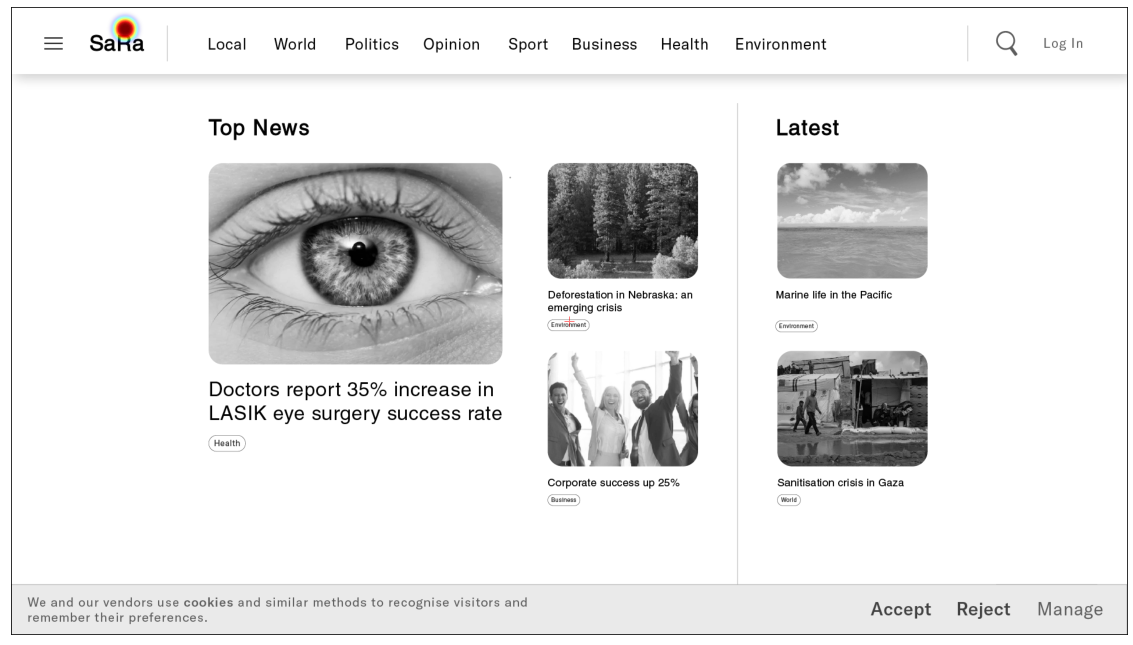

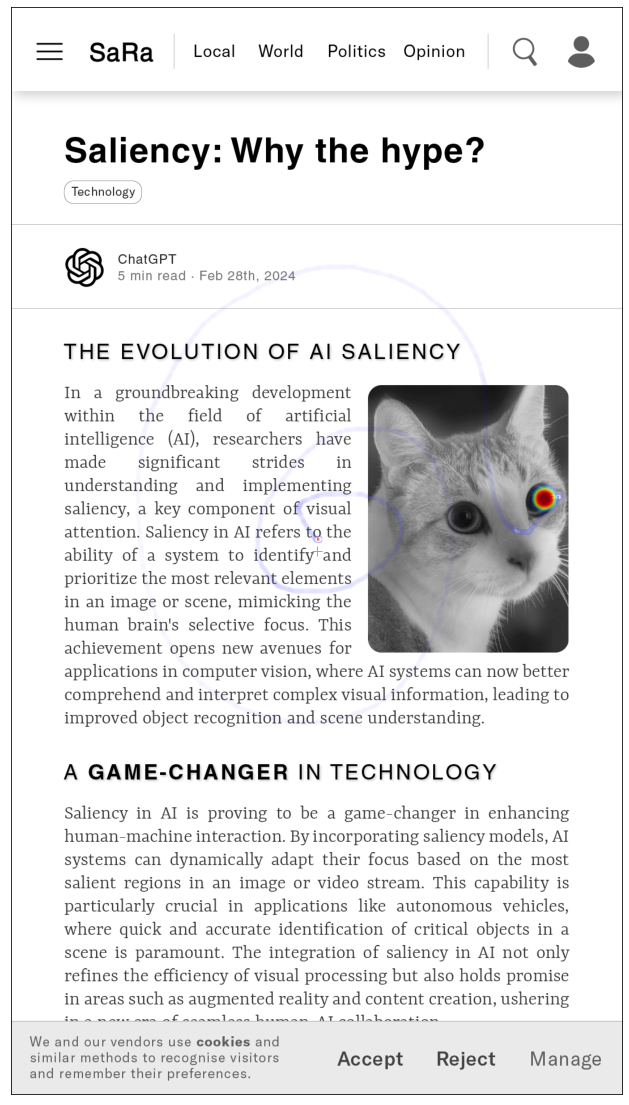

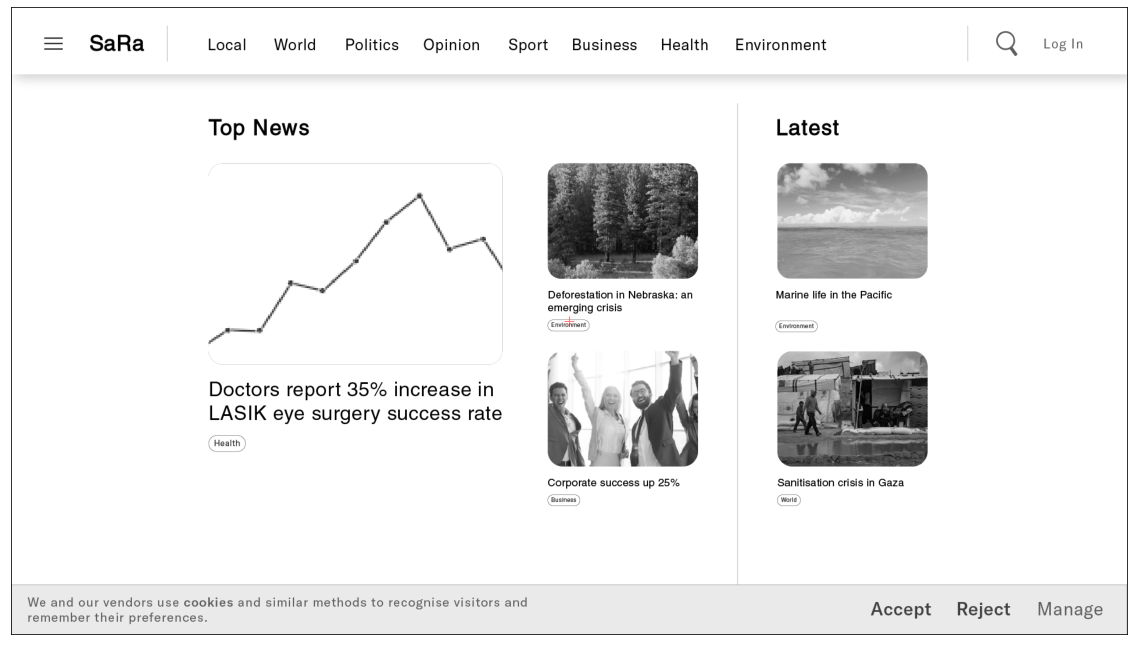

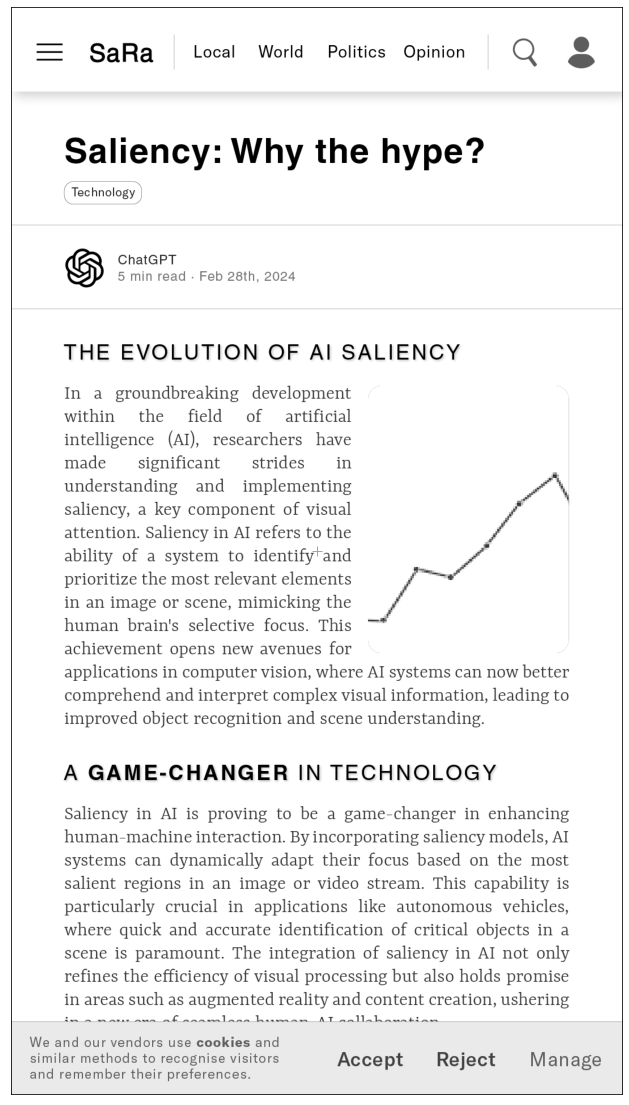

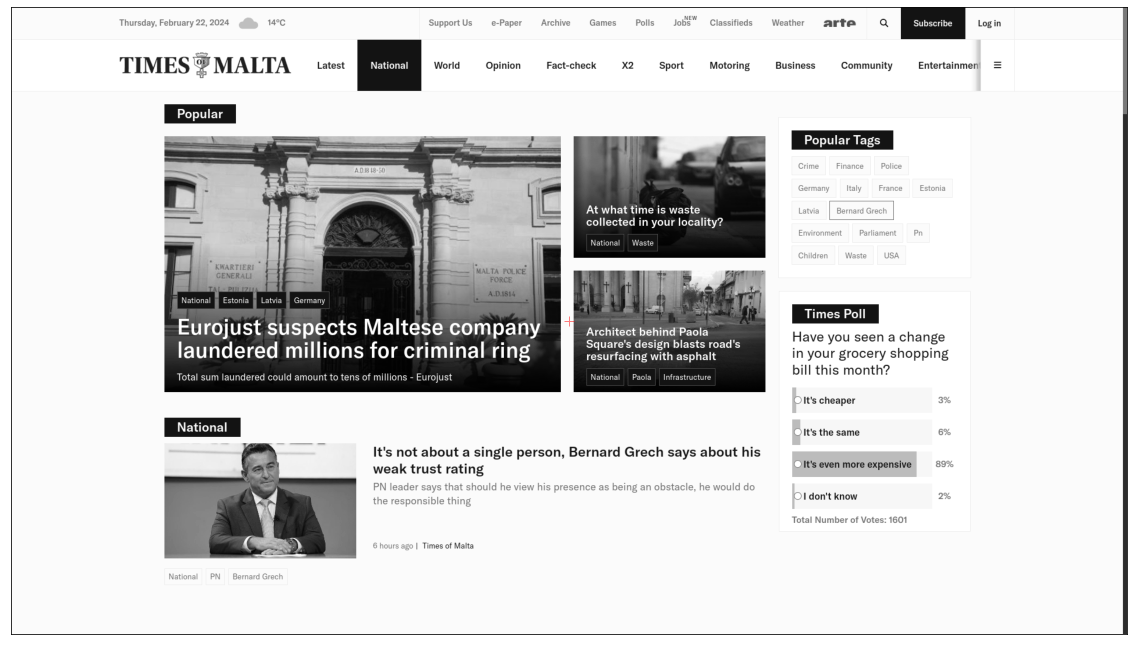

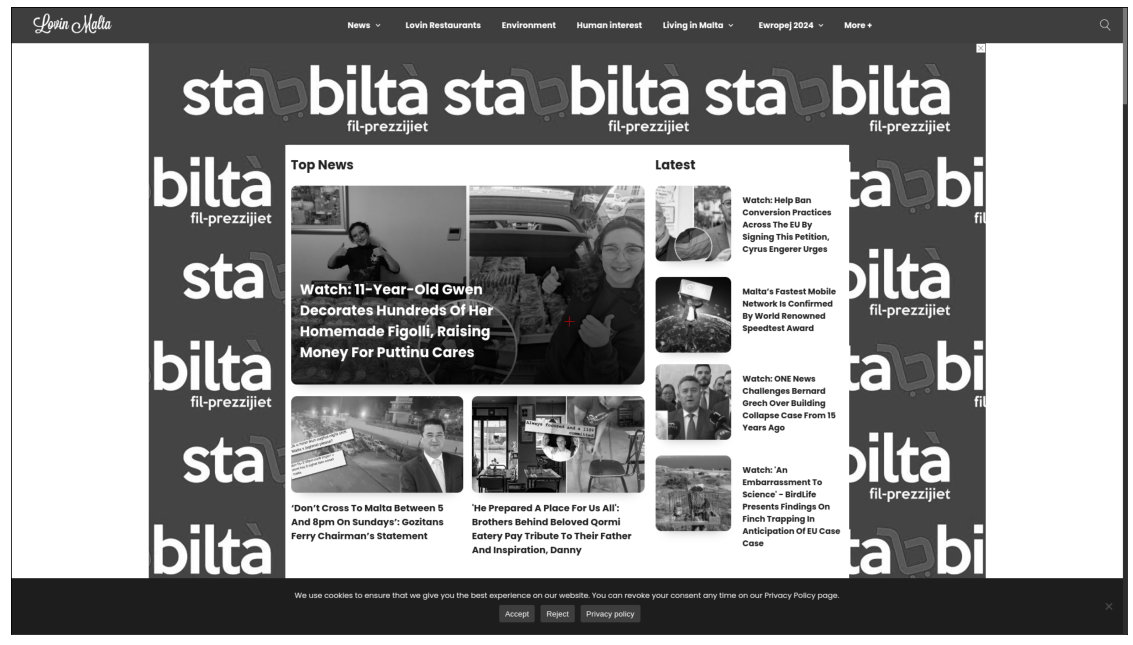

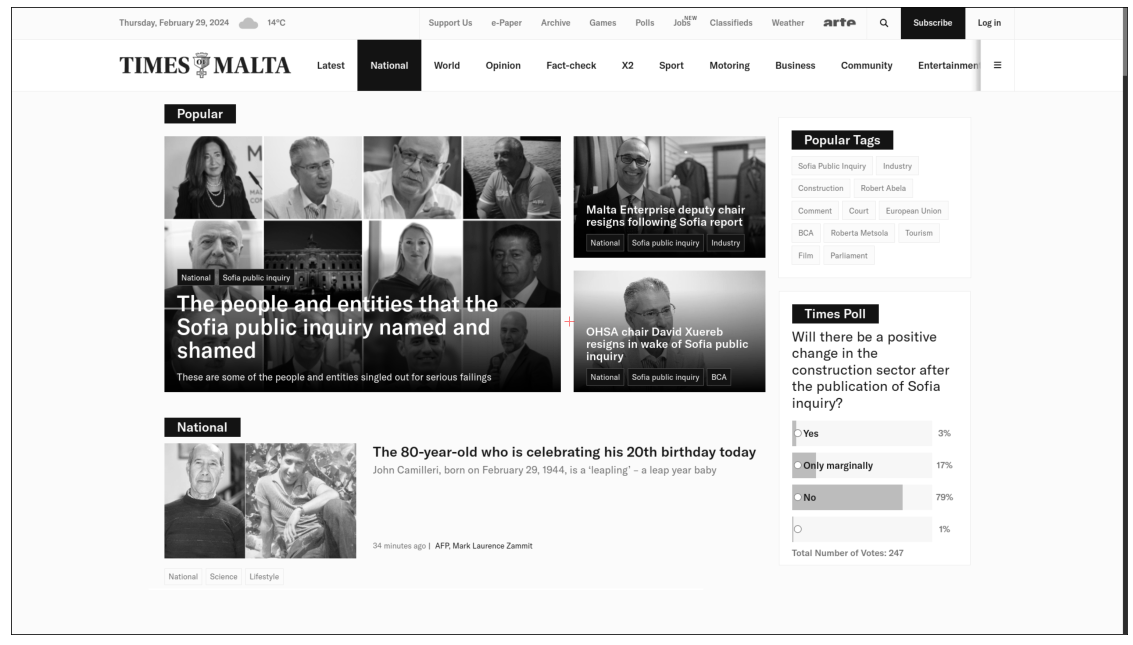

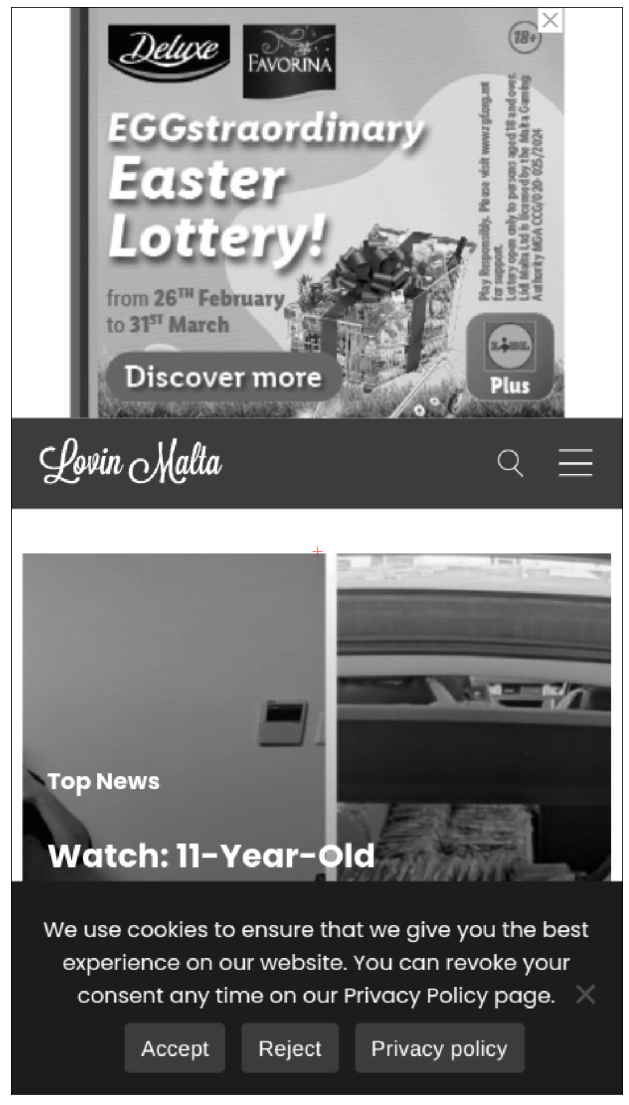

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('jet')(np.linspace(0, 1, 256))
gray_array = plt.get_cmap('bwr')(np.linspace(0, 1, 256))

# Make it so color_array is transparent at 0 and solid at 1
color_array[:,-1] = np.linspace(0,1.0,ncolors)
gray_array[:,-1] = np.linspace(0,1.0,ncolors)


map_object = LinearSegmentedColormap.from_list(name='coolwarm_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)

map_object = LinearSegmentedColormap.from_list(name='gray_alpha',colors=gray_array)
plt.register_cmap(cmap=map_object)

# Assuming imgs, mouse_positions, and final_positions are defined

# Plot all images and mouse movements
for img in imgs:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(cv2.cvtColor(imgs[img], cv2.COLOR_BGR2GRAY), cmap='gray')

    img_x = imgs[img].shape[1]
    img_y = imgs[img].shape[0]

    # print(img_x, img_y)

    # Add all final positions to a heatmap
    heatmap = np.zeros(imgs[img].shape[:2])
    movements = np.zeros(imgs[img].shape[:2])

    for mouse_movement in mouse_positions_interpolated[img]:
        mouse_positions_interpolated[img][mouse_movement] = np.array(mouse_positions_interpolated[img][mouse_movement])

        # Add points to the heatmap intermittently
        for i in range(0, len(mouse_positions_interpolated[img][mouse_movement]), 1):
            x, y  = mouse_positions_interpolated[img][mouse_movement][i]

            # Scale by the user's image dimensions such that they match the image
            # x = int(x * img_x / dimensions[img][mouse_movement]['width'])
            # y = int(y * img_y / dimensions[img][mouse_movement]['height'])

            # print(x, y)

            add_circle_to_heatmap(movements, x, y, radius=5, intensity=10)

    for mouse_movement in final_positions[img]:
        final_position = final_positions[img][mouse_movement].copy()

        # Scale by the user's image dimensions such that they match the image
        # final_position[0] = int(final_position[0] * img_x / dimensions[img][mouse_movement]['width'])
        # final_position[1] = int(final_position[1] * img_y / dimensions[img][mouse_movement]['height'])

        # Give the final position padding in a circle size of 5
        add_circle_to_heatmap(heatmap, final_position[0], final_position[1], radius=20, intensity=10)

    # Add a cross in the middle of the image
    ax.plot(img_x / 2, img_y / 2, 'r+', markersize=10, markeredgewidth=1, alpha=0.5)

    heatmap = cv2.GaussianBlur(heatmap, (31, 31), 5)

    ax.imshow(movements, cmap='gray_alpha', alpha=2)
    ax.imshow(heatmap, cmap='coolwarm_alpha', alpha=1)
    

    plt.xticks([]), plt.yticks([])
    plt.show()


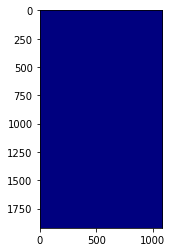

In [29]:
plt.imshow(heatmap, cmap='jet')